# AirBnB : Part 2, Model Selection ALL CITIES

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd

import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,RandomizedLogisticRegression

from sklearn.svm import SVC
from sklearn.metrics import r2_score, mean_squared_error,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.grid_search import GridSearchCV

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

from xgboost import XGBClassifier
from utils import rstr,distance

airBColor= '#ff5a5f'
airBColor2= '#008489'

/home/ramon/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationW

### Add frequency reviews and distance to highlights

In [2]:
df = pd.read_csv('../../data/all_cities/dataset_for_modeling.csv')

In [3]:
df.shape

(11377, 65)

In [4]:
df.drop('listings_per_host',axis=1,inplace =True)

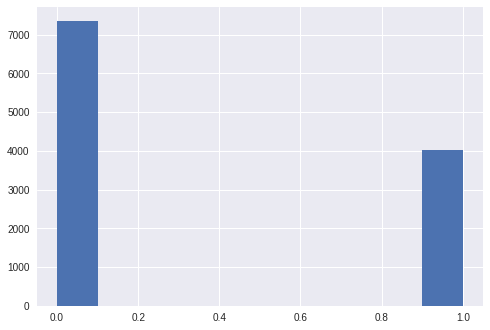

In [5]:
df.multihost.hist()

### Filter on listings with high reviews number

### Fill the missing data

In [6]:
df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent


## Linear Model and R-squared

In [7]:
TARGET_CLASSIFICATION ='multihost'
y = df[TARGET_CLASSIFICATION]

X = df.drop(TARGET_CLASSIFICATION,axis=1)

### Train test split

In [8]:
def balanced_subsample(y, size=None):

    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample

In [9]:
rebalanced_index = balanced_subsample(y)

In [10]:
X,y = X.loc[rebalanced_index],y.loc[rebalanced_index]

In [11]:
y.value_counts()

1    4027
0    4027
Name: multihost, dtype: int64

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,stratify=y)
features = pd.Series(X.columns)
#scaler = MinMaxScaler()

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)


In [13]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=-1,scoring="recall")
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_

### Logistic Regression

In [14]:
lm = LogisticRegression(C=1e5)
lm.fit(X_train,y_train)
prediction = lm.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

[[625 180]
 [176 630]]
             precision    recall  f1-score   support

          0       0.78      0.78      0.78       805
          1       0.78      0.78      0.78       806

avg / total       0.78      0.78      0.78      1611



### Random Forest

In [ ]:
clf = RandomForestClassifier()
params={}
best_clf = cv_optimize(clf,params,X_train,y_train)

print(best_clf)

prediction = best_clf.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
[[629 176]
 [224 582]]
             precision    recall  f1-score   support

          0       0.74      0.78      0.76       805
          1       0.77      0.72      0.74       806

avg / total       0.75      0.75      0.75      1611



### XGB

In [ ]:
params = {
    'max_depth':[9],
    'min_child_weight':[2],
    'learning_rate' :[0.1],
    'gamma':[0.0],
    'n_estimators':[100]
}

clf = XGBClassifier()

best_clf = cv_optimize(clf,params,X_train,y_train)

print(best_clf)
prediction = best_clf.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

In [ ]:
features_weights = pd.DataFrame.from_dict(best_clf.booster().get_fscore(),orient="index")
features_weights.columns = ['fscore']

features_weights.sort_values(by='fscore',ascending=False).head(40).plot(kind='bar',title='',color=airBColor,figsize=(12,12))

### Keras

In [ ]:

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

params = {
    'epochs':[500],
     'batch_size':[128]
}

def create_model():

    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_initializer='uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model


clf = KerasClassifier(build_fn=create_model, verbose=0)

best_clf = cv_optimize(clf,params,X_train.values,y_train.values)

print(best_clf)
prediction = best_clf.predict(X_test.values)
print confusion_matrix(y_test.values,prediction>.5)
print classification_report(y_test.values,prediction>.5)